# Assignment 1: Implementing Backpropagation



### Version 1.1

Change Log
- 1.1: (January 13 4:00PM) Updated points allocation.

### **✏️ To Edit**

Navigate to the top of the page and select `File > Download` or `File > Save a copy in Drive` to edit.

### To submit

You can download the notebook using `File > Download > Download .ipynb`. Submit a completed copy of your notebook with the final graphs rendered on MarkUS along with your submission for the written questions.

### Overview


In the programming portion of this assignment we will be implementing a automatic differentiation framework from scratch. This will be broken into two steps:

* In part 1, you will implement a simple logistic regression and a gradient descent (GD) step.

* In part 2, you will extend your implementation to a mutli-layered perceptron and fit it using the same gradient implementation.

All the places where you need to implement something are marked with `# YOUR CODE HERE`.

All the places where you need to answer a question about your observations or interpretations are marked with `# YOUR RESPONSE HERE`.

### The Datasets

For this homework we will work with two simple datasets of two 2d points. The classes are represented using binary targets that are either 0 or 1.

Thus the features have a shape of `dataset_size x 2` and our targets have a shape of
`dataset_size x 1`.

The moons dataset which consists of two interlocking crescents. And the circles dataset which consists of separating an outer ring from an inner circle.

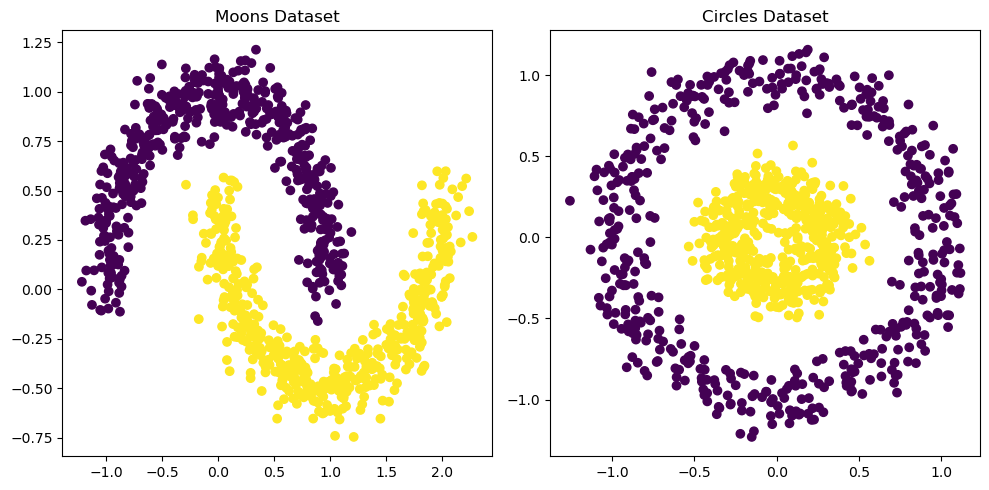

In [2]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split

# Data Generation Functions
def generate_moons(n_samples=1000, noise=0.1):
    X, y = make_moons(n_samples=n_samples, noise=noise, random_state=42)
    return X.reshape(-1, 2), y.reshape(-1, 1)

def generate_circles(n_samples=1000, noise=0.1, factor=0.3):
    X, y = make_circles(n_samples=n_samples, noise=noise, factor=factor, random_state=42)
    return X.reshape(-1, 2), y.reshape(-1, 1)

# Generate datasets
features_moons, targets_moons = generate_moons()
features_circles, targets_circles = generate_circles()

# Split data into train and test sets
features_moons_train, features_moons_test, targets_moons_train, targets_moons_test = \
    train_test_split(features_moons, targets_moons, test_size=0.2, random_state=42)

features_circles_train, features_circles_test, targets_circles_train, targets_circles_test = \
    train_test_split(features_circles, targets_circles, test_size=0.2, random_state=42)

# Visualize the datasets
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(features_moons[:, 0], features_moons[:, 1], c=targets_moons, cmap='viridis')
plt.title('Moons Dataset')
plt.subplot(122)
plt.scatter(features_circles[:, 0], features_circles[:, 1], c=targets_circles, cmap='viridis')
plt.title('Circles Dataset')
plt.tight_layout()
plt.show()

## The Module

In class, we learned about the concept of a computational graph made up of variables connected by operations. In this assignment we will put that into practice by implementing our own simple neural network library. Similar to existing libraries like [TensorFlow](https://www.tensorflow.org/api_docs/python/tf/Module), [PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) and [Flax](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/module.html) we will build our library out of a series of neural network modules. Modules are the building blocks of neural network, like as a layer, activation functions, or normalization. In all of these frameworks modules are built to be composable, allowing complex networks to be built from simpler components.

However, unlike the above frameworks we will **not** be building on top of an automatic differentiation engine and will be implementing the backward pass ourselves. Thus, in our case a module will encapsulate a parametric function and an implementation of that function's vector-Jacobian product (vJp). To achieve this we will use a simple `Module` class that builds directly on top of NumPy.

Each module must implement two methods:

* `forward` which computes the function $y = f_\theta(x; t)$, and
* `backward` which computes the functions vector-Jacobian products $v\frac{\partial y}{\partial x}$ and $v\frac{\partial y}{∂ θ}$.

Note that in our case, we treat the partial derivatives with respect to the parameters and the input separately.
* The vJps with for the inputs should be returned as a tuple, one entry for each argument.
* The vJps for the parameters should be *added* to their respective entries in the `_grad_parameters` dictionary.

When invoked using `__call__` or `()`, the module will run the forward pass and storing intermediate results in memory for efficiently computing the vJp during the backward pass. This includes the inputs $x$, outputs $y$ of the function, and any side inputs $t$.

We often don't want to compute the gradient with respect to all the arguments to our function $f$ (e.g. $t$). Therefore, we will maintain the convention we only compute the derivative with respect to positional arguments. Python allows us to enforce which arguments must be passed positionally and which must be given using keywords by adding `/ , *` as a delimiter in the function signature.

Finally, for simplicity we will only allow our modules to return a single tensor as an output.

In [3]:
class Module:
    """A component of a neural network that we can take the derivative with respect to."""
    _parameters: dict[str, NDArray]
    """Parameters of the module."""
    _parameter_grads: dict[str, NDArray]
    """Gradients of the parameters."""

    _inputs: tuple[NDArray, ...] | None
    """The stashed inputs to the module from the most recent forward pass."""
    _input_kwargs: dict[str, NDArray] | None
    """The stahed side arguments to the module from the most recent pass."""
    _output: NDArray | None
    """The stashed output of the module from the most recent forward pass."""

    def __init__(self):
        self._parameters = {}
        self._parameter_grads = {}
        self._inputs = None
        self._input_kwargs = None
        self._output = None

    def forward(self, *args: list[NDArray], **kwargs) -> NDArray:
        """
        Compute the forward pass of the module and return the output.

        If derivatives are required this method should *not* be called directly. Instead,
        you should invoke it using module(*args, **kwargs).

        Args:
            *args: List of input NDArrays we want to take a derivative with respect to
            **kwargs: Additional keyword arguments we will not produce gradients for

        Returns:
            NDArray: Output of the forward pass
        """
        ...

    def backward(self, grad_output: NDArray) -> tuple[NDArray, ...]:
        """
        Accumulate gradients for the parameters of the module and return the input gradients.

        Args:
            grad_output (NDArray): Gradient of the loss with respect to the module's output

        Returns:
            tuple[NDArray, ...]: Gradients with respect to the module's inputs
        """
        ...

    def get_parameters(self):
        """Return the parameters of the module and all its submodules."""
        return self._parameters

    def get_parameter_grads(self):
        """Return the gradients of the parameters of the module and all its submodules."""
        return self._parameter_grads

    def __call__(self, *args: NDArray, **kwargs) -> NDArray:
        """Run the forward pass of the module and populate the computation graph."""
        self._inputs = args
        self._input_kwargs = kwargs
        self._output = self.forward(*args, **kwargs)
        return self._output

    def zero_grad(self):
        """Reset all the gradents with respect to the parameters to zero."""
        self._parameter_grads = {
            name: np.zeros_like(value) for name, value in self._parameters.items()
        }


def merge_dicts(**kwargs: dict[str, NDArray]) -> dict[str, NDArray]:
    """A helper function for merging dictionaries of numpy arrays."""
    return {kw + '.' + k: v for kw, d in kwargs.items() for k, v in d.items()}

TypeError: 'type' object is not subscriptable

## Testing vector-jacobian product implementations

In this assignment we will provide you with a handy utility for testing your module implementations: `test_vjp_inputs` and `test_vjp_parameters`.

These functions compare the results of computing the jacobain of the model using a sqeuence of numerical gradients $\frac{\partial y}{\partial x}\mathbb u\approx\frac{f(\mathbb x + h\mathbb u) - f(\mathbb x - h\mathbb u)}{2h}$ for small $h$. To the results of computing the jacobian using your custom vJP implementations.

In [4]:
from typing import Callable

def compute_jacobians(
    func: Callable[[], np.ndarray],
    x: np.ndarray,
    backward_func: Callable[[np.ndarray], np.ndarray],
    epsilon: float = 1e-6
) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute both analytical and numerical Jacobians for a given function with respect to a single input.

    Args:
        func: The forward function that returns the output.
        x: The input array to compute Jacobians with respect to.
        backward_func: The backward function to compute analytical Jacobians.
        epsilon: The step size for finite differences (default: 1e-6).

    Returns:
        A tuple of (analytical_jac, numerical_jac).
    """
    output = func()
    analytical_jac = np.zeros(output.shape + x.shape)
    numerical_jac = np.zeros(output.shape + x.shape)

    # Compute analytical Jacobian
    for out_idx in np.ndindex(output.shape):
        output_grad = np.zeros_like(output)
        output_grad[out_idx] = 1
        grad = backward_func(output_grad)
        analytical_jac[out_idx + (...,)] = grad

    # Compute numerical Jacobian
    for in_idx in np.ndindex(x.shape):
        original_value = x[in_idx].copy()
        x[in_idx] = original_value + epsilon
        output_plus = func()
        x[in_idx] = original_value - epsilon
        output_minus = func()
        x[in_idx] = original_value  # Restore original value
        numerical_jac[(...,) + in_idx] = (output_plus - output_minus) / (2 * epsilon)

    return analytical_jac, numerical_jac


def test_vjp_inputs(module: Module, *inputs: NDArray, **kwargs) -> None:
    def forward():
        return module(*inputs, **kwargs)

    def backward(grad_output):
        return module.backward(grad_output)

    for i, input_array in enumerate(inputs):
        analytical_jac, numerical_jac = compute_jacobians(
            func=forward,
            x=input_array,
            backward_func=lambda g: backward(g)[i]
        )

        np.testing.assert_allclose(
            analytical_jac, numerical_jac,
            rtol=1e-3, atol=1e-5,
            err_msg=f'Gradient check failed for input {i}'
        )

    print("All input gradients passed the test.")

def test_vjp_parameters(module: Module, *inputs: NDArray, **kwargs) -> None:
    parameters = module.get_parameters()

    def forward():
        return module(*inputs, **kwargs)

    for param_name, param_value in parameters.items():
        def backward(grad_output):
            module.zero_grad()
            module.backward(grad_output)
            return module.get_parameter_grads()[param_name]

        analytical_jac, numerical_jac = compute_jacobians(
            func=forward,
            x=param_value,
            backward_func=backward
        )

        np.testing.assert_allclose(
            analytical_jac, numerical_jac,
            rtol=1e-3, atol=1e-5,
            err_msg=f'Gradient check failed for parameter {param_name}'
        )

    print("All parameter gradients passed the test.")

TypeError: 'type' object is not subscriptable

## An example module

For reference here is a trival operation that computes an operation:

$
    f_\alpha(a, b; s) = \cases{\alpha(a + b) & s = false \\ \alpha (a - b)  & s = true}
$


In [5]:
class AddOrSubtractAndMultiply(Module):
    def __init__(self, alpha: float = 0.1):
        super().__init__()
        self._parameters['alpha'] = np.array(alpha)
        self.zero_grad()

    def forward(self, a: NDArray, b: NDArray, /, *, subtract: bool = False) -> NDArray:
        """
        Add or subtract the two batches of scalers and then multiply by a scalar.

        Args:
            a: A batch of scalers with shape (batch_size, 1)
            b: A batch of scalers with shape (batch_size, 1)

        KWArgs:
            subtract (bool, optional): Whether to subtract the tensors. Defaults to False.

        Returns:
            NDArray: Result of the operation
        """
        value = self._parameters['alpha']
        return (a + b) * value if not subtract else (a - b) * value

    def backward(self, grad_output: NDArray) -> tuple[NDArray, NDArray]:
        """ Compute the backward pass for this module.

        Args:
            grad_output: (batch_size, 1)

        Returns:
            Gradient of the loss with respect to each of the of this module
        """
        value = self._parameters['alpha']
        subtract = self._input_kwargs['subtract']
        output = self._output

        grad_a = value * grad_output
        grad_b = value * grad_output if not subtract else -value * grad_output
        self._parameter_grads['alpha'] += (grad_output * self._output / value).sum()

        return (grad_a, grad_b)

a = np.random.randn(10, 1)
b = np.random.randn(10, 1)
add_or_subtract_and_multiply = AddOrSubtractAndMultiply()

# Example usage
c = add_or_subtract_and_multiply(a, b, subtract=False)

test_vjp_inputs(
    add_or_subtract_and_multiply,
    a,
    b,
    subtract=False
)

test_vjp_parameters(
    add_or_subtract_and_multiply,
    a,
    b,
    subtract=False
)

NameError: name 'Module' is not defined

## Part 1: Logistic Regression with Full Batch GD [17 pts]

As a warm-up we implement a basic version of logistic regression with a cross entropy loss. Logistic regression with this objective does not have a closed form solution. Here we will simply apply full batch gradient decent to find a close to optimal solution.


$$
    J(\mathbf w, \mathbf b) = \frac{1}{N}\sum_{i=0}^{N} L_\theta (x_i, t_i)
$$

$$
    L_{BCE} = -[t\log(σ(\mathbf z)) + (1 - t)\log(1 - \sigma(\mathbf z))]
$$

$$
    \mathbf z = \mathbf w^\top x + \mathbf b
$$






### Part 1.1 Implement the binary cross entropy loss [5 pts]

Implement the `forward` and `backard` pass for the binary cross entropy loss. Each funciton is worth 0.5 points.

Note that this module implements both the cross enropy loss and averaging over the dataset. Thus it should return a scalar.

In [ ]:
class BinaryCrossEntropy(Module):
    """Binary cross entropy loss"""
    def forward(self, logits: NDArray, /, *, targets: NDArray) -> NDArray:
        """
        Compute the binary cross entropy loss.

        Args:
            logits: Predicted logits, shape (batch_size, 1)
            targets: True binary labels, shape (batch_size, 1)

        Returns:
            Average binary cross entropy loss across the batch with should be a scaler.
        """
        assert logits.shape == targets.shape, f"Shapes mismatch: logits {logits.shape}, targets {targets.shape}"
        assert logits.ndim == 2 and logits.shape[1] == 1, f"Expected logits shape (batch_size, 1), got {logits.shape}"

        # YOUR CODE HERE
        sigmoid_z = 1 / (1 + np.exp(-logits))

        loss = targets*np.log(sigmoid_z) + (1-targets)*np.log(1-sigmoid_z)
        xentropy_avg = 1/ len(loss) * np.sum(loss)


    def backward(self, grad_output: NDArray) -> tuple[NDArray]:
        """
        Compute the gradient of the binary cross entropy loss.

        Args:
            grad_output: Gradient of the loss with respect to the output, scalar

        Returns:
            A tuple containing the gradient with respect to logits, shape (batch_size, 1)
        """
        assert grad_output.shape == (), f"Expected scalar grad_output, got shape {grad_output.shape}"

        # YOUR CODE HERE
        dl_dz = 
        dz_dx = 
        logits_grad = 
        return (logits_grad,) # This a tuple of length one containing the gradient w.r.t. the logits

test_vjp_inputs(
    BinaryCrossEntropy(),
    np.random.randn(10, 1),
    targets=np.random.randint(0, 2, 10)[:, None]
)

### Part 1.2: Implement a general linear layer [5 pts]

One of the most common layers types in all of deep learning is a "linear" layer. This layer will serve as a component in both our logistic regression and later in our MLP. These are typically actually *affine* (not linear) transformations since they include a bias term:  

$$f_{\mathbf{W}, {\mathbf{b}}}(x) = W\mathbf x + \mathbf b$$

where the parameter $W \in \mathbb{R^{n\times m}}$ and $\mathbb b \in \mathbb R^n$.

In [ ]:
class Linear(Module):
    """A parameterized affine transformation

    Parameters:
        weights: Weight matrix, shape (input_size, output_size)
        bias: Bias vector, shape (output_size,)
    """
    def __init__(self, input_size: int, output_size: int):
        super().__init__()
        self._parameters['weights'] = np.random.randn(input_size, output_size) * np.sqrt(2. / input_size)
        self._parameters['bias'] = np.zeros((output_size,))
        self.zero_grad()

    def forward(self, features: NDArray) -> NDArray:
        """
        Forward pass of the linear layer.

        Args:
            features: Input features, shape (batch_size, input_size)

        Returns:
            Output of the linear layer, shape (batch_size, output_size)
        """
        assert features.ndim == 2, f"Expected 2D input, got shape {features.shape}"
        assert features.shape[1] == self._parameters['weights'].shape[0], f"Input size mismatch: {features.shape[1]} != {self._parameters['weights'].shape[0]}"

        # YOUR CODE HERE

    def backward(self, grad_output: NDArray) -> tuple[NDArray]:
        """
        Backward pass of the linear layer.

        Args:
            grad_output: Gradient of the loss with respect to the output, shape (batch_size, output_size)

        Returns:
            Gradient with respect to the input features, shape (batch_size, input_size)
        """
        assert grad_output.ndim == 2, f"Expected 2D grad_output, got shape {grad_output.shape}"
        assert grad_output.shape[1] == self._parameters['weights'].shape[1], f"Gradient output size mismatch: {grad_output.shape[1]} != {self._parameters['weights'].shape[1]}"

        # YOUR CODE HERE
        return (grad_input,)

linear = Linear(10, 5)
features = np.random.randn(3, 10)
test_vjp_inputs(linear, features)
test_vjp_parameters(linear, features)

### Part 1.3: Implement the binary logistic regression [2 pts]

Chain together your linear layer and cross entropy layer to form a complete logistic regression module. Note that the forward pass should return a scalar **loss**.

In [ ]:
class BinaryLogisticRegression(Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = Linear(input_size, 1)
        self.loss = BinaryCrossEntropy()
        self.zero_grad()

    def forward(self, features: NDArray, /, *, targets: NDArray) -> NDArray:
        """
        Forward pass of the logistic regression model.

        Args:
            features: Input features, shape (batch_size, input_size)
            targets: True binary labels, shape (batch_size, 1)

        Returns:
            NDArray: Scalar loss value
        """
        assert features.ndim == 2, f"Expected 2D features, got shape {features.shape}"
        assert targets.ndim == 2 and targets.shape[1] == 1, f"Expected targets shape (batch_size, 1), got {targets.shape}"
        assert features.shape[0] == targets.shape[0], f"Batch size mismatch: features {features.shape[0]}, targets {targets.shape[0]}"

        # YOUR CODE HERE

    def backward(self, grad_output: NDArray) -> tuple[NDArray]:
        """
        Backward pass of the logistic regression model.

        Args:
            grad_output: Gradient of the loss with respect to the output, scalar

        Returns:
            A tuple containing the gradient with respect to the input features, shape (batch_size, input_size)
        """
        assert grad_output.shape == (), f"Expected scalar grad_output, got shape {grad_output.shape}"

        # YOUR CODE HERE

    def predict(self, features: NDArray) -> NDArray:
        """
        Predict binary labels using the logistic regression model. # TODO (lev) improve this docstring

        Args:
            features (NDArray): Input features, shape (batch_size, input_size)

        Returns:
            NDArray: Predicted binary labels, shape (batch_size, 1)
        """
        logits = self.linear(features)
        sigmoid = 1 / (1 + np.exp(-logits))
        return (sigmoid >= 0.5).astype(int)

    def get_parameters(self):
        return self.linear.get_parameters()

    def get_parameter_grads(self):
        return self.linear.get_parameter_grads()

test_vjp_inputs(
    BinaryLogisticRegression(10),
    np.random.randn(3, 10),
    targets=np.random.randint(0, 2, 3)[:, None]
)

## Part 1.4: Full batch Gradient Descent [5 pts]

Implement a single step of gradient decent on our classifier with respect to the entire dataset.

> ⚠
>
> We will reuse this function for learning our MLP. Thus you should make it as general as possible!

> 💡 Hint
>
> Use `get_parameter_grads` and `get_parameters` to make your gradent decent implementation agnostic to how the classifier is implemented.


In [ ]:
def gd_step(classifier: Module, input_features: NDArray, targets: NDArray, learning_rate: float) -> float:
    """Perform a single step of gradient descent on the parameters of the classifier.

        Args:
            classifier: The module we will take a step on. It should accept
                input_features and targets as arguments. It will be updated in-place.
            input_features: A (batch_size, input_size) array of input features
            targets: A (batch_size, 1) array of integer targets
            learning_rate: The learning rate to use for SGD.

        Returns:
            The loss of the model on the batch.
    """

    # YOUR CODE HERE
    return loss

## Part 1.5 Run the training and visualize the results [0 pts]

Observe, how the classification accuracy changes with training. Why can't we get a training accurcay of above about 90% on the moons dataset?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.colors import ListedColormap

def compute_accuracy(model, features, targets):
    predictions = model.predict(features)
    return np.mean(predictions == targets)

def fit_logistic_regression(
        model: Module,
        train_features: NDArray,
        train_targets: NDArray,
        val_features: NDArray,
        val_targets: NDArray,
        num_iterations: int = 1000,
        learning_rate: float = 0.01,
        eval_every: int = 10
    ):
    steps = []
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    tb = tqdm(range(num_iterations), desc='Training', leave=False)

    for i in tb:
        loss = gd_step(model, train_features, train_targets, learning_rate)

        if i % eval_every == 0:
            steps.append(i)
            train_losses.append(loss)
            train_acc = compute_accuracy(model, train_features, train_targets)
            val_acc = compute_accuracy(model, val_features, val_targets)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            tb.set_postfix(train_loss=loss, train_acc=train_acc, val_acc=val_acc)

    return steps, train_losses, train_accuracies, val_accuracies

def plot_decision_boundary(model, X, y, ax=None):
    if ax is None:
        ax = plt.gca()

    x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
                           np.arange(x2_min, x2_max, 0.02))
    Z = model.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)

    cmap = ListedColormap(['#FFAAAA', '#AAAAFF'])
    ax.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolor='black')
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    return ax

def plot_results(
        *,
        steps,
        train_losses,
        train_accuracies,
        val_accuracies,
        model,
        X,
        y,
    ):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 18))

    # Plot loss
    ax1.plot(steps, train_losses)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss over Iterations')

    # Plot accuracies
    ax2.plot(steps, train_accuracies, label='Train Accuracy')
    ax2.plot(steps, val_accuracies, label='Validation Accuracy')
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Train and Validation Accuracy over Iterations')
    ax2.set_ylim(0, 1)
    ax2.legend()

    ax3 = plot_decision_boundary(model, X, y, ax=ax3)
    ax3.set_title('Final Decision Boundary')

    plt.tight_layout()
    plt.show()

YOUR RESPONSE HERE:
(Double-click to type)



In [ ]:
# Prepare the data
targets_moons_train = targets_moons_train.reshape(-1, 1)  # Reshape to (n_samples, 1)
targets_moons_test = targets_moons_test.reshape(-1, 1)  # Reshape to (n_samples, 1)

# Initialize and train the model
input_size = features_moons_train.shape[1]
model = BinaryLogisticRegression(input_size)
steps, train_losses, train_accuracies, val_accuracies = fit_logistic_regression(
    model,
    features_moons_train,
    targets_moons_train,
    features_moons_test,
    targets_moons_test,
    num_iterations=1000,
    learning_rate=0.0001,
    eval_every=10
)

# Plot the training curves
plot_results(
    steps=steps,
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    val_accuracies=val_accuracies,
    model=model,
    X=features_moons,
    y=targets_moons
)

## Part 2: Multi-Layer Perceptron (MLP) [13 pts]

A Multi-Layer Perceptron (MLP) for binary classification extends logistic regression by adding hidden layers allowing the model to learn a more expressive feature basis and fit non-linearly separable data.

Forward Pass:
* $\mathbf{a}^{[0]} = \mathbf x$
* For each layer $l$ from $1$ to $N$:
	* $\mathbf{z}^{[l]} = W^{[l]}\mathbf{a}^{[l-1]} + \mathbf{b}^{[l]}$
	* $\mathbf{a}^{[l]} = g(\mathbf{z}^{[l]})$
* $y = W^{O}\mathbf{a}^{[N]} + \mathbf{b}^{O}$
* $L_{BCE} = -[t\log(\sigma(y)) + (1 - t)\log(1 - \sigma(y))]$

Here $g$ is our activation function. For this assignment we will consider 2 activation functions $tanh(x)$ and $ReLU(x) = max(0, x)$.

### Part 2.1: Activation Functions [3 pts]

In [ ]:
class Tanh(Module):
    def forward(self, input: NDArray):
        """Run tanh activation function elementwise.

        Args:
            input: Input data, shape (batch_size, input_size)

        Returns:
            Output of the tanh activation function, shape (batch_size, input_size)
        """
        # YOUR CODE HERE

    def backward(self, grad_output: NDArray):
        """Compute the gradient of the tanh activation function.

        Args:
            grad_output: Gradient of the loss with respect to the output, shape (batch_size, input_size)

        Returns:
            Gradient of the loss with respect to the input, shape (batch_size, input_size)
        """
        # YOUR CODE HERE

test_vjp_inputs(Tanh(), np.random.randn(10, 1))

In [ ]:
class ReLU(Module):
    """ReLU activation function"""
    def forward(self, input: NDArray) -> NDArray:
        """Run ReLU activation function elementwise.

        Args:
            input: Input data, shape (batch_size, input_size)

        Returns:
            Output of the ReLU activation function, shape (batch_size, input_size)
        """
        # YOUR CODE HERE

    def backward(self, grad_output: NDArray) -> tuple[NDArray]:
        """Compute the gradient of the ReLU activation function.

        Args:
            grad_output: Gradient of the loss with respect to the output, shape (batch_size, input_size)

        Returns:
            A tuple containing the gradient of the loss with respect to the input, shape (batch_size, input_size)
        """
        # YOUR CODE HERE

test_vjp_inputs(ReLU(), np.random.randn(10, 1))

### Part 2.2: The Sequential module [5 pts]


Many neural networks consist of a sequence of modules with a single output and input that are chained together. Unlike the modules we have worked with to this point the `Sequential` module represents a more abstract operation. Like its [pytorch equvilent](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html), it represents composing together a sequence of modules and feeding the output of one into the input of the next in order.



In [ ]:
class Sequential(Module):
    """Run a sequence of layers feeding the outputs of one into another."""

    layers: tuple[Module]
    """Layers in the sequence."""

    def __init__(self, *layers: Module):
        super().__init__()
        self.layers = layers
        self.zero_grad()

    def forward(self, input: NDArray):
        """Run the sequence of layers on the input.

        Args:
            input: Input data, shape (batch_size, input_size)

        Returns:
            Output of the last layer, shape (batch_size, output_size)
        """
        # YOUR CODE HERE

    def backward(self, grad_output: NDArray) -> tuple[NDArray]:
        """Compute the gradient of the loss with respect to the input.

        Args:
            grad_output: Gradient of the loss with respect to the output, shape (batch_size, output_size)

        Returns:
            A tuple containing the gradient of the loss with respect to the input, shape (batch_size, input_size)
        """
        # YOUR CODE HERE

    def get_parameters(self):
        return merge_dicts(
            **{f'{i}': layer.get_parameters()
                for i, layer in enumerate(self.layers)
                if isinstance(layer, Module)}
        )

    def get_parameter_grads(self):
        return merge_dicts(
            **{f'{i}': layer.get_parameter_grads()
               for i, layer in enumerate(self.layers)
               if isinstance(layer, Module)}
        )

    def zero_grad(self):
        for layer in self.layers:
            if isinstance(layer, Module):
                layer.zero_grad()

input_size = 10
hidden_size = 5
output_size = 3
sequential = Sequential(
    Linear(input_size, hidden_size),
    ReLU(),
    Linear(hidden_size, output_size)
)


test_vjp_inputs(sequential, np.random.randn(10, 10))
test_vjp_parameters(sequential, np.random.randn(10, 10))

### Part 2.3 The Binary Classification MLP [5 pts]

Now combining everything we have done so far will implement a simple multilayer perceptorn with an arbitrary number of hidden layers and widths per layer.

We will seperate our MLP into two parts the `self.net` and the `self.loss`. You're first task will be to fill the layers list with the apropriate moduels to implement the computation graph
descibed above.

Next you will implement the forward pass, and finally the backward pass.

In [ ]:
class BinaryClassificationMLP(Module):
    """
    A multi-layer perceptron for binary classification.
    """

    def __init__(self, input_size: int, hidden_sizes: list[int], activation=ReLU):
        """Create the MLP.

        Args:
            input_size: The size of the input vector.
            hidden_sizes: A list of the sizes of the hidden layers.
            activation: The activation function to use.
        """
        super().__init__()
        sizes = [input_size] + hidden_sizes + [1]
        layers = []

        # YOUR CODE HERE

        self.net = Sequential(*layers)
        self.loss = BinaryCrossEntropy()

    def forward(self, features: NDArray, targets: NDArray) -> NDArray:
        """Compute the loss of the network on these features and targets.

        Args:
            features: A (batch_size, input_size) array of input features.
            targets: A (batch_size, 1) array of binary targets.

        Returns:
            The loss of the network on these features and targets.
        """
        # YOUR CODE HERE

    def backward(self, grad_output: NDArray) -> tuple[NDArray]:
        """Compute the gradient of the loss with respect to the parameters of the network.

        Args:
            grad_output: A (batch_size, 1) array of gradients of the loss with respect to the output of the network.

        Returns:
            A tuple containing a (batch_size, input_size) array of gradients of the loss with respect to the input features.
        """
        # YOUR CODE HERE

    def predict(self, features: NDArray) -> NDArray:
        logits = self.net(features)
        sigmoid = 1 / (1 + np.exp(-logits))
        return (sigmoid >= 0.5).astype(int)

    def get_parameters(self):
        return self.net.get_parameters()

    def get_parameter_grads(self):
        return self.net.get_parameter_grads()

    def zero_grad(self):
        self.net.zero_grad()


mlp = BinaryClassificationMLP(input_size=2, hidden_sizes=[10, 10], activation=ReLU)
test_vjp_inputs(mlp, np.random.randn(10, 2), targets=np.random.randint(0, 2, 10)[:, None])
test_vjp_parameters(mlp, np.random.randn(10, 2), targets=np.random.randint(0, 2, 10)[:, None])

### Part 2.4: Train your MLP [0 pts]

Train you newly minted multi-layer perceptron. Try switching out the activation function and training on both datasets. What happens as you increase the depth of your network? What about changing its width? Do you notice anything when you change from $ReLU$ to $tanh$ activations?

In [ ]:
def fit_mlp(
        model,
        X,
        y,
        X_val,
        y_val,
        num_iterations: int = 1000,
        learning_rate: float = 0.01,
        eval_every: int = 10
    ):
    steps = []
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    tb = tqdm(range(num_iterations), desc='Training', leave=False)

    for i in tb:
        loss = gd_step(model, X, y, learning_rate)

        if i % eval_every == 0:
            steps.append(i)
            train_losses.append(loss)
            train_acc = compute_accuracy(model, X, y)
            val_acc = compute_accuracy(model, X_val, y_val)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            tb.set_postfix(train_loss=loss, train_acc=train_acc, val_acc=val_acc)

    return steps, train_losses, train_accuracies, val_accuracies


In [ ]:
# Train and evaluate MLP with Sigmoid activation on moons dataset
mlp = BinaryClassificationMLP(input_size=2, hidden_sizes=[10, 10], activation=ReLU)

train_features = features_moons_train # features_circles_train
train_targets = targets_moons_train # targets_circles_train
val_features = features_moons_test # features_circles_test
val_targets = targets_moons_test # targets_circles_test

steps, losses, train_acc, val_acc = fit_mlp(
    mlp, train_features, train_targets, val_features, val_targets,
    num_iterations=1000, learning_rate=0.001
)

# Plot results for moons dataset
plot_results(
    steps=steps,
    train_losses=losses,
    train_accuracies=train_acc,
    val_accuracies=val_acc,
    model=mlp,
    X=train_features,
    y=train_targets
)

YOUR RESPONSE HERE:
(Double-click to type)

